# Toxic Tweet Detection Using LSTM

In this project, we will attempt to segregate tweets from the OLID dataset based on 3 subtasks.

Subtask A- Classifying into toxic and non-toxic tweets  
Subtask B- Classifying into non-toxic, toxic directed, and toxic undirected tweets.  
Subtask C- Classifying into non-toxic, toxic directed to an individual, toxic directed to a group and other tweets.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertConfig
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.optim as optim

First let us view the dataset.

## The Dataset

### Visualization

In [19]:
dataset=pd.read_csv('Datasets\olid-training-v1.0.csv')

In [23]:
dataset_a=dataset[['id','tweet','subtask_a']]
dataset_b=dataset[['id','tweet','subtask_b']]
dataset_c=dataset[['id','tweet','subtask_c']]
dataset_a

id                                              tweet subtask_a
0      86426  @USER She should ask a few native Americans wh...       OFF
1      90194  @USER @USER Go home youâ€™re drunk!!! @USER #M...       OFF
2      16820  Amazon is investigating Chinese employees who ...       NOT
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT
...      ...                                                ...       ...
13235  95338  @USER Sometimes I get strong vibes from people...       OFF
13236  67210  Benidorm âœ…  Creamfields âœ…  Maga âœ…   Not ...       NOT
13237  82921  @USER And why report this garbage.  We don't g...       OFF
13238  27429                                        @USER Pussy       OFF
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT

[13240 rows x 3 columns]

In [21]:
dataset_b_nona=dataset_b.dropna()
dataset_b_nona

id                                              tweet subtask_b
0      86426  @USER She should ask a few native Americans wh...       UNT
1      90194  @USER @USER Go home youâ€™re drunk!!! @USER #M...       TIN
3      62688  @USER Someone should'veTaken" this piece of sh...       UNT
5      97670                  @USER Liberals are all Kookoo !!!       TIN
6      77444                   @USER @USER Oh noes! Tough shit.       UNT
...      ...                                                ...       ...
13223  63482  @USER is advocating for conduct within bounds ...       TIN
13227  87416  @USER @USER @USER @USER Liars like the Antifa ...       TIN
13235  95338  @USER Sometimes I get strong vibes from people...       TIN
13237  82921  @USER And why report this garbage.  We don't g...       TIN
13238  27429                                        @USER Pussy       UNT

[4400 rows x 3 columns]

In [22]:
dataset_c_nona=dataset_c.dropna()
dataset_c_nona

id                                              tweet subtask_c
1      90194  @USER @USER Go home youâ€™re drunk!!! @USER #M...       IND
5      97670                  @USER Liberals are all Kookoo !!!       OTH
7      52415  @USER was literally just talking about this lo...       GRP
9      13384  @USER Canada doesnâ€™t need another CUCK! We a...       IND
12     28414  @USER you are a lying corrupt traitor!!! Nobod...       IND
...      ...                                                ...       ...
13212  93164  @USER @USER Everything else was ten years ago....       IND
13223  63482  @USER is advocating for conduct within bounds ...       GRP
13227  87416  @USER @USER @USER @USER Liars like the Antifa ...       GRP
13235  95338  @USER Sometimes I get strong vibes from people...       IND
13237  82921  @USER And why report this garbage.  We don't g...       OTH

[3876 rows x 3 columns]

In [6]:
dataset

id                                              tweet subtask_a  \
0      86426  @USER She should ask a few native Americans wh...       OFF   
1      90194  @USER @USER Go home youâ€™re drunk!!! @USER #M...       OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   
...      ...                                                ...       ...   
13235  95338  @USER Sometimes I get strong vibes from people...       OFF   
13236  67210  Benidorm âœ…  Creamfields âœ…  Maga âœ…   Not ...       NOT   
13237  82921  @USER And why report this garbage.  We don't g...       OFF   
13238  27429                                        @USER Pussy       OFF   
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT   

      subtask_b subtask_c  
0           UNT       NOT  
1           TIN       IND  
2           NOT       NOT  
3           UNT       NOT  
4           NOT       NOT  
...         ...       ...  
13235       TIN       IND  
13236       NOT       NOT  
13237       TIN       OTH  
13238       UNT       NOT  
13239       NOT       NOT  

[13240 rows x 5 columns]

Let us visualize the data

#### Subtask_A

In [28]:
# Count the number of rows with 'OFF' label in subtask_a column
off_count = dataset_a[dataset_a['subtask_a'] == 'OFF'].shape[0]

# Count the number of rows with 'NOT' label in subtask_a column
not_count = dataset_a[dataset_a['subtask_a'] == 'NOT'].shape[0]

print(f'Number of rows with OFF label: {off_count}')
print(f'Number of rows with NOT label: {not_count}')

Number of rows with OFF label: 4400
Number of rows with NOT label: 8840


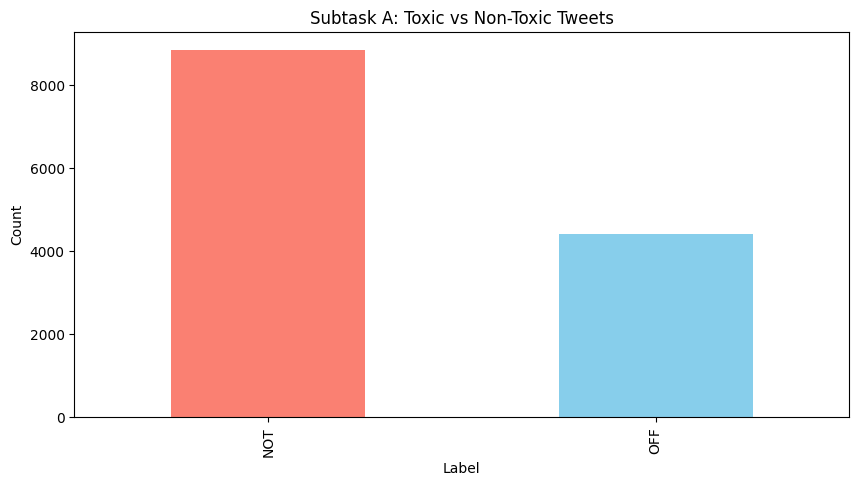

In [29]:
colors_a = {'OFF': 'salmon', 'NOT': 'skyblue'}

plt.figure(figsize=(10, 5))
dataset_a['subtask_a'].value_counts().sort_index().plot(kind='bar', color=[colors_a[label] for label in dataset_a['subtask_a'].unique()])
plt.title('Subtask A: Toxic vs Non-Toxic Tweets')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


#### Subtask_B

In [32]:
unt_count = dataset_b_nona[dataset_b_nona['subtask_b'] == 'UNT'].shape[0]
tin_count = dataset_b_nona[dataset_b_nona['subtask_b']== 'TIN'].shape[0]
#not2_count = dataset[dataset['subtask_b'] == 'NOT'].shape[0]

print(f'Number of rows with UNT label: {unt_count}')
print(f'Number of rows with TIN label: {tin_count}')
#print(f'Number of rows with NOT label: {not2_count}')

Number of rows with UNT label: 524
Number of rows with TIN label: 3876


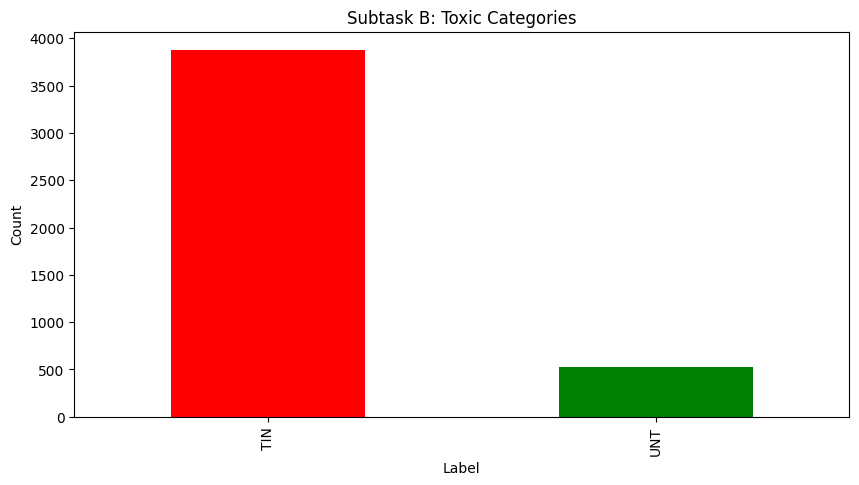

In [33]:
colors_b = {'UNT': 'red', 'TIN': 'green'}

plt.figure(figsize=(10, 5))
dataset_b_nona['subtask_b'].value_counts().sort_index().plot(kind='bar', color=[colors_b[label] for label in dataset_b_nona['subtask_b'].unique()])
plt.title('Subtask B: Toxic Categories')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


#### Improving the dataset

In [ ]:
p

#### Subtask_C

In [ ]:
ind_count = dataset[dataset['subtask_c'] == 'IND'].shape[0]
grp_count = dataset[dataset['subtask_c'] == 'GRP'].shape[0]
oth_count = dataset[dataset['subtask_c']== 'OTH'].shape[0]
not3_count = dataset[dataset['subtask_c'] == 'NOT'].shape[0]

print(f'Number of rows with IND label: {ind_count}')
print(f'Number of rows with GRP label: {grp_count}')
print(f'Number of rows with OTH label: {oth_count}')
print(f'Number of rows with NOT label: {not3_count}')

Number of rows with IND label: 2407
Number of rows with GRP label: 1074
Number of rows with OTH label: 395
Number of rows with NOT label: 9364


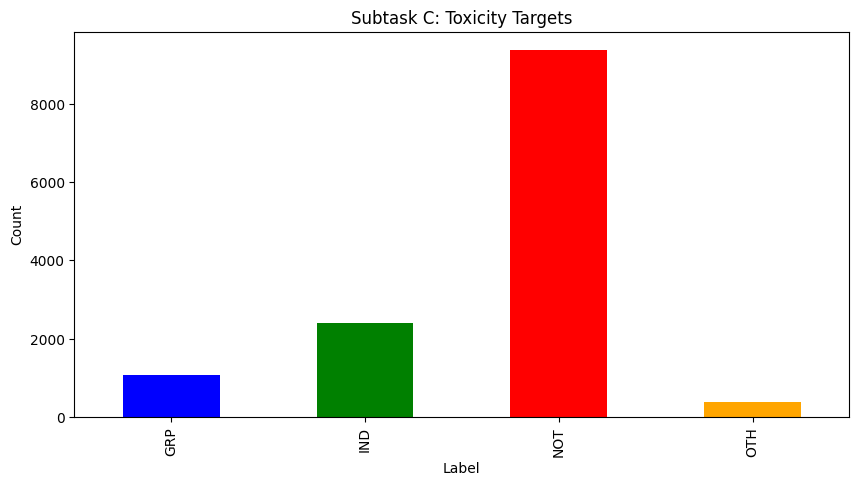

In [ ]:
colors_c = {'NOT':'blue','IND': 'green', 'GRP': 'orange', 'OTH': 'red'}
plt.figure(figsize=(10, 5))
dataset['subtask_c'].value_counts().sort_index().plot(kind='bar', color=[colors_c[label] for label in dataset['subtask_c'].unique()])
plt.title('Subtask C: Toxicity Targets')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Data Preprocessing

In [ ]:
not_labels = dataset[dataset['subtask_a'] == 'NOT']
off_labels = dataset[dataset['subtask_a'] == 'OFF']

# Take a subset of the larger class to make it balanced
not_labels_subset = not_labels.sample(n=len(off_labels), random_state=42)

# Concatenate the balanced subsets
balanced_df = pd.concat([not_labels_subset, off_labels])


Number of rows with OFF label: 4400
Number of rows with NOT label: 4400


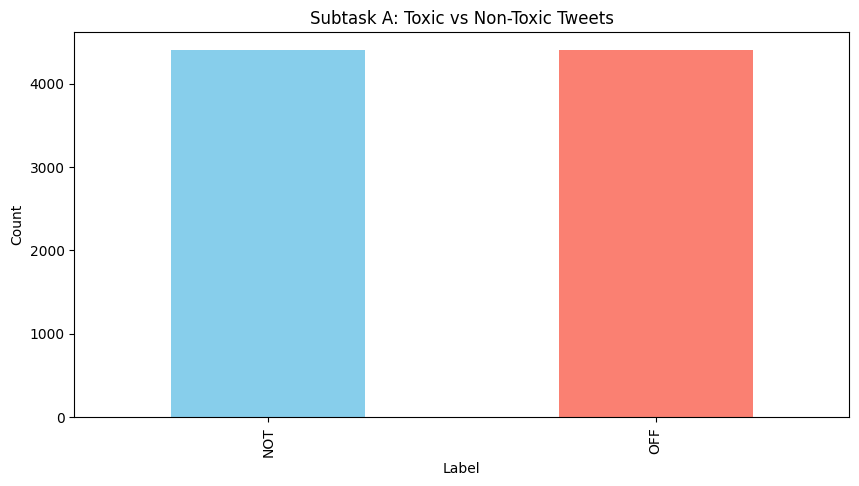

In [ ]:
# Count the number of rows with 'OFF' label in subtask_a column
off_count = balanced_df[balanced_df['subtask_a'] == 'OFF'].shape[0]

# Count the number of rows with 'NOT' label in subtask_a column
not_count = balanced_df[balanced_df['subtask_a'] == 'NOT'].shape[0]

print(f'Number of rows with OFF label: {off_count}')
print(f'Number of rows with NOT label: {not_count}')
colors_a = {'OFF': 'salmon', 'NOT': 'skyblue'}

plt.figure(figsize=(10, 5))
balanced_df['subtask_a'].value_counts().sort_index().plot(kind='bar', color=[colors_a[label] for label in balanced_df['subtask_a'].unique()])
plt.title('Subtask A: Toxic vs Non-Toxic Tweets')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [ ]:
X= balanced_df['tweet'].values
y= balanced_df['subtask_a'].values

In [ ]:
print('Tweets:\n',X)
print('\nLabels:\n',y)

Tweets:
 ['@USER @USER @USER She is a role model Adam you are not!'
 '@USER Dang do his NC fans that pay the salaries know this ðŸ¤«ðŸ¤«ðŸ¤£ðŸ˜œðŸ˜œðŸ˜œ'
 '@USER So as per new promo it will be Maulis journey so you are making her as a shield because she is the saving grace left the leads less said better'
 ...
 '@USER Sometimes I get strong vibes from people and this manâ€™s vibe is tens of millions of murders - he is more dangerous than DT.'
 "@USER And why report this garbage.  We don't give a crap." '@USER Pussy']

Labels:
 ['NOT' 'NOT' 'NOT' ... 'OFF' 'OFF' 'OFF']


#### Label Encoding

In [ ]:
label_encoder=LabelEncoder()
encoded_labels= label_encoder.fit_transform(y)
encoded_labels_tensor = torch.tensor(encoded_labels)
print("Encoded Labels:", encoded_labels_tensor)

Encoded Labels: tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32)


#### Tokenizing the data

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_tweets = [torch.tensor(tokenizer.encode(tweet, add_special_tokens=True)) for tweet in X]
for i, (tweet, tokens) in enumerate(zip(X, tokenized_tweets)):
    print(f"Tweet {i + 1}:", tweet)
    print("Token IDs:", tokens)
    print()

Tweet 1: @USER @USER @USER She is a role model Adam you are not!
Token IDs: tensor([ 101, 1030, 5310, 1030, 5310, 1030, 5310, 2016, 2003, 1037, 2535, 2944,
        4205, 2017, 2024, 2025,  999,  102])

Tweet 2: @USER Dang do his NC fans that pay the salaries know this ðŸ¤«ðŸ¤«ðŸ¤£ðŸ˜œðŸ˜œðŸ˜œ
Token IDs: tensor([  101,  1030,  5310,  4907,  2290,  2079,  2010, 13316,  4599,  2008,
         3477,  1996, 20566,  2113,  2023,  1098,  2100, 29647,  1077,  1098,
         2100, 29647,  1077,   100,   102])

Tweet 3: @USER So as per new promo it will be Maulis journey so you are making her as a shield because she is the saving grace left the leads less said better
Token IDs: tensor([  101,  1030,  5310,  2061,  2004,  2566,  2047, 19430,  2009,  2097,
         2022,  5003, 15859,  2015,  4990,  2061,  2017,  2024,  2437,  2014,
         2004,  1037,  6099,  2138,  2016,  2003,  1996,  7494,  4519,  2187,
         1996,  5260,  2625,  2056,  2488,   102])

Tweet 4: @USER Even though he has prov

In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased')
vocab_size = config.vocab_size
vocab_size

30522

In [ ]:
max_sequence_length = max(len(tweet) for tweet in tokenized_tweets)
max_sequence_length

210

#### Padding Sequences

In [ ]:
padded_sequences = pad_sequence(tokenized_tweets, batch_first=True, padding_value=0)
# Print the padded sequences
print("Padded Sequences:\n", padded_sequences)

Padded Sequences:
 tensor([[ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0],
        ...,
        [ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0]])


#### Splitting data into training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels_tensor, test_size=0.2, random_state=42)

## LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(embedded, x_lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Fix: Use hidden_size from the model attributes
        hidden_size = self.lstm.hidden_size
        
        hidden = self.dropout(torch.cat((output[:, -1, :hidden_size], output[:, 0, hidden_size:]), dim=1) if self.lstm.bidirectional else output[:, -1, :])
        return self.fc(hidden)

In [ ]:
# vocab_size defined above
embedding_dim = 100  
hidden_dim = 64  
output_size = len(label_encoder.classes_)   
num_layers = 1
bidirectional = True  
dropout = 0.5  
model = LSTMModel(vocab_size,  hidden_dim, output_size, num_layers, bidirectional, dropout)


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 4
for epoch in range(num_epochs):
    print("training")
    model.train()
    optimizer.zero_grad()

    print("outputs")
    # Forward pass with sequence lengths
    outputs = model(X_train, torch.tensor([len(seq) for seq in X_train]))

    print("loss")
    # Compute loss
    loss = criterion(outputs, torch.tensor(y_train, dtype=torch.long))

    print("backward")
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


training
outputs
loss
backward


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17776\3111424800.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(y_train, dtype=torch.long))


Epoch [1/4], Loss: 0.6983
training
outputs
loss
backward
Epoch [2/4], Loss: 0.6984
training
outputs
loss
backward
Epoch [3/4], Loss: 0.6972
training
outputs
loss
backward
Epoch [4/4], Loss: 0.6963


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    test_outputs = model(X_test, torch.tensor([len(seq) for seq in X_test]))

    # Get predicted labels
    _, predicted = torch.max(test_outputs, 1)

    # Convert predicted tensor to numpy array
    predicted = predicted.numpy()
    print(predicted)
    # Convert the true labels tensor to numpy array
    y_test_numpy = y_test.numpy()

    # Calculate accuracy
    accuracy = (predicted == y_test_numpy).sum().item() / len(y_test_numpy)
    print(f'Test Accuracy: {accuracy:.4f}')

    # You can compute other metrics (precision, recall, F1 score) based on your task
    # ...


[0 0 0 ... 0 0 0]
Test Accuracy: 0.4949


In [ ]:

# For multi-class classification, you might want to use a confusion matrix or classification report
from sklearn.metrics import confusion_matrix, classification_report

# Convert the predicted labels to the original class labels
predicted_labels = label_encoder.inverse_transform(predicted)


# Ensure both y_test and predicted_labels are in integer format
y_test_int = label_encoder.transform(label_encoder.inverse_transform(y_test_numpy))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, predicted))

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_int, predicted))



Confusion Matrix:
[[871   0]
 [889   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       871
           1       0.00      0.00      0.00       889

    accuracy                           0.49      1760
   macro avg       0.25      0.50      0.33      1760
weighted avg       0.24      0.49      0.33      1760



C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1